# PLTR:
## Stock Prediction AI

## Libaries and loading

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns

In [ ]:
from IPython.display import Image

In [ ]:
# Seaborn plot styling
sns.set(style = 'white', font_scale = 2)

## Data preperation

In [ ]:
# 0) Imports & Plot Styling

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pathlib

sns.set(style='white', font_scale=2)

from google.colab import drive
drive.mount('/content/drive')

# 1) Path Setup

"""
Paths to the CSV files in Google Drive.
For each ticker (PLTR and NASDAQ), I exported a separate file from Yahoo Finance
and placed it in the same folder.
"""

DATA_DIR   = pathlib.Path("/content/drive/MyDrive/Final Project")
PLTR_PATH  = DATA_DIR / "PLTR (11).csv"
IXIC_PATH  = DATA_DIR / "^IXIC (10).csv"   # NASDAQ Composite (^IXIC)

print("Using PLTR file:", PLTR_PATH)
print("Using NASDAQ file:", IXIC_PATH)

# 2) Robust Loader for any ticker

"""
Read the CSV file, normalize the column names, and find the best available
closing price column. This is to prevent bugs from slightly different schemas.
"""

def load_ticker(csv_path: pathlib.Path):
    df = pd.read_csv(csv_path)

    # Normalize column names
    df.columns = [str(c).strip() for c in df.columns]

    # Best available closing price column
    close_col = None
    for cand in ["Close", "close", "CLOSE", "Adj Close", "AdjClose"]:
        if cand in df.columns:
            close_col = cand
            break

    if close_col is None:
        raise ValueError(f"No close column found in file: {csv_path}")

    # Convert key numeric columns
    df[close_col] = pd.to_numeric(df[close_col], errors="coerce")
    if "Volume" in df.columns:
        df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")
    if "High" in df.columns:
        df["High"] = pd.to_numeric(df["High"], errors="coerce")
    if "Low" in df.columns:
        df["Low"] = pd.to_numeric(df["Low"], errors="coerce")

    df = df.dropna(subset=[close_col])

    close_np = df[close_col].astype(float).to_numpy()

    return df, close_np


# 3) Load Data (PLTR + NASDAQ)

pltr_df, pltr_close   = load_ticker(PLTR_PATH)
nasdaq_df, nasdaq_close = load_ticker(IXIC_PATH)

print(f"Loaded {len(pltr_close)} closing prices from PLTR.")
print("First 5 PLTR close prices:", pltr_close[:5])
print("Last 5 PLTR close prices:", pltr_close[-5:])

print(f"Loaded {len(nasdaq_close)} closing prices from NASDAQ (^IXIC).")
print("First 5 NASDAQ close prices:", nasdaq_close[:5])
print("Last 5 NASDAQ close prices:", nasdaq_close[-5:])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using PLTR file: /content/drive/MyDrive/Final Project/PLTR (11).csv
Using NASDAQ file: /content/drive/MyDrive/Final Project/^IXIC (10).csv
Loaded 1302 closing prices from PLTR.
First 5 PLTR close prices: [9.5  9.46 9.2  9.03 9.9 ]
Last 5 PLTR close prices: [168.449997 167.490005 170.690002 176.080002 177.919998]
Loaded 1302 closing prices from NASDAQ (^IXIC).
First 5 NASDAQ close prices: [11167.509766 11326.509766 11075.019531 11332.490234 11154.599609]
Last 5 NASDAQ close prices: [23365.689453 23275.919922 23413.669922 23454.089844 23505.140625]


In [ ]:
# 4) Feature Engineering + Normalize + Train/Test Split

"""
Here I create 5, 10, and 20 day moving averages from the closing prices,
merge in NASDAQ (^IXIC) data, and add technical indicators that capture
trend, momentum, and volatility.
"""

from sklearn.preprocessing import MinMaxScaler

# --- Make sure data is sorted by date ---
pltr_df["Date"]   = pd.to_datetime(pltr_df["Date"])
nasdaq_df["Date"] = pd.to_datetime(nasdaq_df["Date"])

pltr_df   = pltr_df.sort_values("Date").reset_index(drop=True)
nasdaq_df = nasdaq_df.sort_values("Date").reset_index(drop=True)

# --- Merge NASDAQ (Close + Volume) into PLTR on Date ---
merged = pltr_df.merge(
    nasdaq_df[["Date", "Close", "Volume"]].rename(
        columns={"Close": "NAS_Close", "Volume": "NAS_Volume"}
    ),
    on="Date",
    how="inner"
)

# --- Moving averages on PLTR Close (your original features) ---
merged["MA_5"]  = merged["Close"].rolling(window=5).mean()
merged["MA_10"] = merged["Close"].rolling(window=10).mean()
merged["MA_20"] = merged["Close"].rolling(window=20).mean()

# ==========================================================
# Technical Indicator Helper Functions (PLTR-based)
# ==========================================================

def compute_RSI(series, period=14):
    delta = series.diff()
    gain  = delta.clip(lower=0)
    loss  = -delta.clip(upper=0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    return 100 - (100 / (1 + rs))

def compute_MACD(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - macd_signal
    return macd, macd_signal, macd_hist

def compute_bollinger_width(series, window=20, num_std=2):
    ma  = series.rolling(window).mean()
    std = series.rolling(window).std()
    upper = ma + num_std * std
    lower = ma - num_std * std
    return (upper - lower) / (ma + 1e-9)

def compute_ROC(series, period=10):
    return series.pct_change(periods=period)

def compute_ATR(df, period=14):
    # Needs PLTR High/Low/Close
    high_low   = df["High"] - df["Low"]
    high_close = (df["High"] - df["Close"].shift()).abs()
    low_close  = (df["Low"] - df["Close"].shift()).abs()
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return true_range.rolling(period).mean()

def compute_stochastic_k(df, window=14):
    low_min  = df["Low"].rolling(window).min()
    high_max = df["High"].rolling(window).max()
    return 100 * (df["Close"] - low_min) / (high_max - low_min + 1e-9)

# ==========================================================
# Apply Technical Indicators (all on PLTR)
# ==========================================================

merged["RSI_14"] = compute_RSI(merged["Close"])
merged["MACD"], merged["MACD_signal"], merged["MACD_hist"] = compute_MACD(merged["Close"])
merged["BB_width"] = compute_bollinger_width(merged["Close"])
merged["ROC_10"]   = compute_ROC(merged["Close"])
merged["ATR_14"]   = compute_ATR(merged)
merged["Stoch_K"]  = compute_stochastic_k(merged)

# NASDAQ-based features (market factor)
merged["NAS_ret_1"] = merged["NAS_Close"].pct_change(1)
merged["NAS_ret_5"] = merged["NAS_Close"].pct_change(5)

# Drop initial rows where indicators or MAs are NaN (warm-up period)
merged = merged.dropna().reset_index(drop=True)

# ==========================================================
# Final Feature Matrix for LSTM
# ==========================================================

feature_cols = [
    "Close", "Volume", "MA_5", "MA_10", "MA_20",     # original PLTR features
    "RSI_14", "MACD", "MACD_signal", "MACD_hist",    # momentum / trend
    "BB_width", "ROC_10", "ATR_14", "Stoch_K",       # volatility + momentum
    "NAS_Close", "NAS_Volume", "NAS_ret_1", "NAS_ret_5"  # market factor
]

print("NUMBER OF FEATURES:", len(feature_cols))

features   = merged[feature_cols].values            # (T, F)
close_vals = merged["Close"].values.reshape(-1, 1)  # (T, 1) – target in USD

# --- Train/Test split: last 100 days into test (same logic as before) ---
split_idx = len(merged) - 100

train_features = features[:split_idx]
test_features  = features[split_idx:]

train_close = close_vals[:split_idx]
test_close  = close_vals[split_idx:]

# --- Scale features and target (close) separately ---
feature_scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler   = MinMaxScaler(feature_range=(0, 1))

feature_scaler.fit(train_features)
close_scaler.fit(train_close)

train_features_scaled = feature_scaler.transform(train_features)
test_features_scaled  = feature_scaler.transform(test_features)

train_close_scaled = close_scaler.transform(train_close)
test_close_scaled  = close_scaler.transform(test_close)

print("Total samples after warm-up:", len(merged))
print("Train samples:", train_features_scaled.shape[0])
print("Test samples:", test_features_scaled.shape[0])
print("Feature dimension:", train_features_scaled.shape[1])
print("First 5 scaled train feature rows:\n", train_features_scaled[:5])

# IMPORTANT: if later code still uses pltr_df (e.g. for last_close), point it to merged
pltr_df = merged

NUMBER OF FEATURES: 17
Total samples after warm-up: 1283
Train samples: 1183
Test samples: 100
Feature dimension: 17
First 5 scaled train feature rows:
 [[0.03457911 0.0975536  0.02619603 0.02541841 0.02365989 0.62586437
  0.23739192 0.1899894  0.53764114 0.08395219 0.42171835 0.01908761
  0.95147887 0.11639909 0.01003035 0.36431769 0.51849251]
 [0.03388055 0.04577668 0.02857225 0.02654662 0.02416641 0.60878943
  0.24189074 0.1925312  0.54247647 0.10702194 0.42592352 0.02271426
  0.8975665  0.07564425 0.01902823 0.12339334 0.36694957]
 [0.03318198 0.02205244 0.03011319 0.02717424 0.02465041 0.60055542
  0.24478322 0.19530554 0.54387325 0.12033078 0.3658912  0.02454667
  0.81720337 0.09291402 0.01154924 0.41973124 0.42834503]
 [0.02885086 0.02020884 0.03103488 0.02748805 0.02499934 0.52010329
  0.24383102 0.1972811  0.53907528 0.11451532 0.33349053 0.02844054
  0.4933922  0.06673029 0.01620561 0.19405645 0.30809822]
 [0.03171499 0.0019419  0.03188456 0.02821279 0.02556589 0.62061311
  0

In [ ]:
# 5) Build sequences + aligned targets

"""
convert flat time series into 60 days windows and assign each window two targets:
a) scaled next-day closing price &
b) a label that uses binary up and down for comparing the next-day closing price to the last day in the window.
"""

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

# How many past days the LSTM sees
LOOKBACK = 60

# We already have from earlier:
# - train_features_scaled, test_features_scaled  (features scaled with feature_scaler)
# - train_close, test_close                      (UNSCALED close: shape (N,1))
# - train_close_scaled, test_close_scaled        (scaled with close_scaler)

def make_sequences(features_scaled, close_scaled, close_unscaled, lookback):
    """
    features_scaled : (N, F)
    close_scaled    : (N, 1)  - scaled close  (kept for API, not used here)
    close_unscaled  : (N, 1)  - raw close in USD
    lookback        : window length

    Returns:
      X          : (M, lookback, F)  input sequences
      y_ret      : (M, 1)           next-day return ( (next - last) / last )
      y_updown   : (M, 1)           1 if next_day_close > last_close_in_window else 0
    """
    N = len(features_scaled)
    X_list = []
    y_ret_list = []
    last_close_list = []
    next_close_list = []

    for i in range(N - lookback):
        # window covers indices [i, ..., i+lookback-1]
        X_seq = features_scaled[i : i + lookback]

        # next day index is i + lookback
        next_idx = i + lookback

        last_close = close_unscaled[next_idx - 1, 0]    # last close in window (USD)
        next_close = close_unscaled[next_idx, 0]        # next-day close (USD)

        # --- regression target: percent return ---
        ret = (next_close - last_close) / last_close    # e.g. 0.01 = +1%

        X_list.append(X_seq)
        y_ret_list.append([ret])
        last_close_list.append(last_close)
        next_close_list.append(next_close)

    X = np.array(X_list)                      # (M, lookback, F)
    y_ret = np.array(y_ret_list)             # (M, 1)

    last_close_arr = np.array(last_close_list).reshape(-1, 1)
    next_close_arr = np.array(next_close_list).reshape(-1, 1)

    # Classification label: does NEXT DAY go up vs LAST DAY IN WINDOW?
    y_updown = (next_close_arr > last_close_arr).astype(float)  # (M, 1)

    return X, y_ret, y_updown


# ---- Build TRAIN and TEST sequences ----
X_train, y_train_sc, y_train_updown = make_sequences(
    train_features_scaled,
    train_close_scaled,
    train_close,
    LOOKBACK
)

X_test, y_test_sc, y_test_updown = make_sequences(
    test_features_scaled,
    test_close_scaled,
    test_close,
    LOOKBACK
)

print("X_train:", X_train.shape)
print("y_train_sc:", y_train_sc.shape, "y_train_updown:", y_train_updown.shape)
print("X_test:", X_test.shape)
print("y_test_sc:", y_test_sc.shape, "y_test_updown:", y_test_updown.shape)


X_train: (1123, 60, 17)
y_train_sc: (1123, 1) y_train_updown: (1123, 1)
X_test: (40, 60, 17)
y_test_sc: (40, 1) y_test_updown: (40, 1)


In [ ]:
# Sanity checks for sequences

print("X_train shape:", X_train.shape)   # (num_train_samples, LOOKBACK, num_features)
print("y_train_sc shape:", y_train_sc.shape)   # (num_train_samples, 1, 1)

print("X_test shape:", X_test.shape)     # (num_test_samples, LOOKBACK, num_features)
print("y_test_sc shape:", y_test_sc.shape)     # (num_test_samples, 1, 1)

print("Example first training window (features):")
print(X_train[0][:3])   # first 3 days in first window
print("First training target (scaled close):", y_train_sc[0])

X_train shape: (1123, 60, 17)
y_train_sc shape: (1123, 1)
X_test shape: (40, 60, 17)
y_test_sc shape: (40, 1)
Example first training window (features):
[[0.03457911 0.0975536  0.02619603 0.02541841 0.02365989 0.62586437
  0.23739192 0.1899894  0.53764114 0.08395219 0.42171835 0.01908761
  0.95147887 0.11639909 0.01003035 0.36431769 0.51849251]
 [0.03388055 0.04577668 0.02857225 0.02654662 0.02416641 0.60878943
  0.24189074 0.1925312  0.54247647 0.10702194 0.42592352 0.02271426
  0.8975665  0.07564425 0.01902823 0.12339334 0.36694957]
 [0.03318198 0.02205244 0.03011319 0.02717424 0.02465041 0.60055542
  0.24478322 0.19530554 0.54387325 0.12033078 0.3658912  0.02454667
  0.81720337 0.09291402 0.01154924 0.41973124 0.42834503]]
First training target (scaled close): [0.11203185]


## Define Model

In [ ]:
# LSTM MODEL

import torch
import torch.nn as nn

class PalantirLSTM(nn.Module):
    def __init__(self, input_size=18, hidden_size=64, num_layers=2, dropout=0.2):
        """
        input_size : number of input features per timestep (now 18 after adding indicators + NASDAQ)
        hidden_size: LSTM hidden dimension
        num_layers : stacked LSTM layers
        dropout    : dropout between LSTM layers
        """
        super().__init__()

        self.hidden_size = hidden_size

        # ------ Shared LSTM encoder ------
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        # ------ Regression head (next-day closing price) ------
        self.regressor = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)   # output: 1 scaled price
        )

        # ------ Classification head (up/down) ------
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        x: (batch, seq_len, 18 features)
        """
        lstm_out, (h_n, c_n) = self.lstm(x)
        h_last = h_n[-1]  # final hidden layer output

        price_pred = self.regressor(h_last)
        updown_prob = self.classifier(h_last)

        return price_pred, updown_prob

## Define Hyperparameters

In [ ]:
# 6) Convert to Torch + DataLoaders

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

batchsize     = 32
hidden_size   = 64
num_layers    = 2
learning_rate = 0.001
epochs        = 50

# to torch tensors
Xtr = torch.tensor(X_train, dtype=torch.float32)
ytr_price  = torch.tensor(y_train_sc,     dtype=torch.float32)  # scaled close
ytr_updown = torch.tensor(y_train_updown, dtype=torch.float32)  # 0/1

Xte = torch.tensor(X_test, dtype=torch.float32)
yte_price  = torch.tensor(y_test_sc,     dtype=torch.float32)
yte_updown = torch.tensor(y_test_updown, dtype=torch.float32)

train_ds = TensorDataset(Xtr, ytr_price, ytr_updown)
test_ds  = TensorDataset(Xte, yte_price, yte_updown)

train_loader = DataLoader(train_ds, batch_size=batchsize, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batchsize, shuffle=False)


# 7) Build model, loss, optimizer

import torch.nn as nn

model = PalantirLSTM(
    input_size=len(feature_cols),   # <<< IMPORTANT: now matches the engineered features
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=0.2
).to(device)

criterion_price  = nn.MSELoss()
criterion_updown = nn.BCELoss()
optimizer        = torch.optim.Adam(model.parameters(), lr=learning_rate)

training_loss_history = []
batch_loss_history    = []

print(model)

Using device: cpu
PalantirLSTM(
  (lstm): LSTM(17, 64, num_layers=2, batch_first=True, dropout=0.2)
  (regressor): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


## Identify Tracked Values

In [ ]:
# Track training progress

# List to store average loss after each epoch
training_loss_history = []

batch_loss_history = []

print("Tracking variables initialized.")

Tracking variables initialized.


## Train Model

In [ ]:
# 8) Train the model

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    num_batches = 0

    for Xb, yb_price, yb_up in train_loader:
        Xb = Xb.to(device)
        yb_price = yb_price.to(device)
        yb_up    = yb_up.to(device)

        optimizer.zero_grad()

        pred_price, pred_up = model(Xb)

        loss_price = criterion_price(pred_price, yb_price)
        loss_up    = criterion_updown(pred_up, yb_up)

        loss = loss_price + loss_up
        loss.backward()
        optimizer.step()

        batch_loss_history.append(loss.item())
        total_loss += loss.item()
        num_batches += 1

    avg_epoch_loss = total_loss / max(num_batches, 1)
    training_loss_history.append(avg_epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}  Avg Loss = {avg_epoch_loss:.4f}")

Epoch 1/50  Avg Loss = 0.6976
Epoch 2/50  Avg Loss = 0.6959
Epoch 3/50  Avg Loss = 0.6948
Epoch 4/50  Avg Loss = 0.6961
Epoch 5/50  Avg Loss = 0.6956
Epoch 6/50  Avg Loss = 0.6943
Epoch 7/50  Avg Loss = 0.6955
Epoch 8/50  Avg Loss = 0.6946
Epoch 9/50  Avg Loss = 0.6944
Epoch 10/50  Avg Loss = 0.6941
Epoch 11/50  Avg Loss = 0.6947
Epoch 12/50  Avg Loss = 0.6937
Epoch 13/50  Avg Loss = 0.6937
Epoch 14/50  Avg Loss = 0.6940
Epoch 15/50  Avg Loss = 0.6938
Epoch 16/50  Avg Loss = 0.6938
Epoch 17/50  Avg Loss = 0.6938
Epoch 18/50  Avg Loss = 0.6941
Epoch 19/50  Avg Loss = 0.6935
Epoch 20/50  Avg Loss = 0.6925
Epoch 21/50  Avg Loss = 0.6936
Epoch 22/50  Avg Loss = 0.6932
Epoch 23/50  Avg Loss = 0.6936
Epoch 24/50  Avg Loss = 0.6934
Epoch 25/50  Avg Loss = 0.6941
Epoch 26/50  Avg Loss = 0.6932
Epoch 27/50  Avg Loss = 0.6931
Epoch 28/50  Avg Loss = 0.6925
Epoch 29/50  Avg Loss = 0.6931
Epoch 30/50  Avg Loss = 0.6933
Epoch 31/50  Avg Loss = 0.6927
Epoch 32/50  Avg Loss = 0.6928
Epoch 33/50  Avg 

## Visualize & Evaluate Model

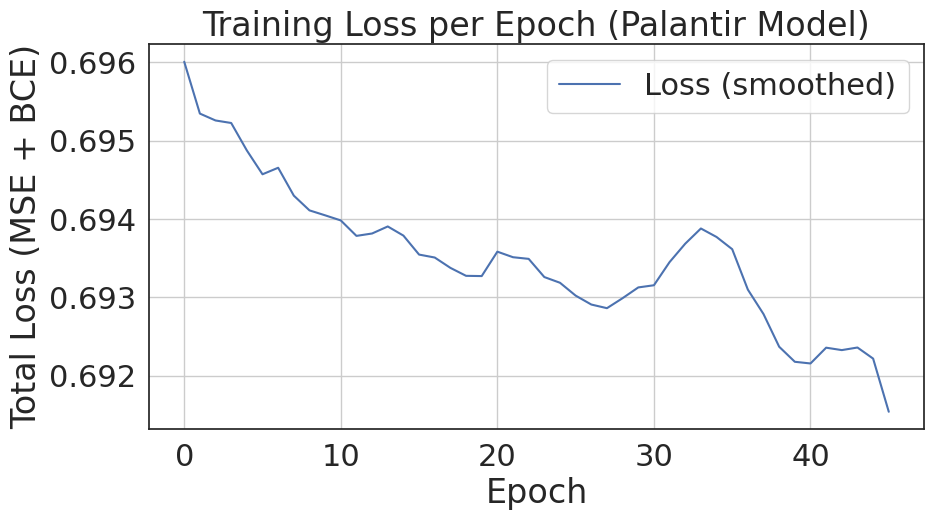

In [ ]:
# 9) Visualize

import numpy as np
import matplotlib.pyplot as plt

def moving_average(x, w=5):
    return np.convolve(x, np.ones(w)/w, mode='valid')

plt.figure(figsize=(10,5))

if len(training_loss_history) >= 5:
    plt.plot(moving_average(training_loss_history, w=5), label="Loss (smoothed)")
else:
    plt.plot(training_loss_history, label="Loss")

plt.title("Training Loss per Epoch (Palantir Model)")
plt.xlabel("Epoch")
plt.ylabel("Total Loss (MSE + BCE)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 10) NEXT-DAY PREDICTION (RETURN + PRICE + PROBABILITIES)

model.eval()

# Scale the entire feature set for consistent prediction
full_features_scaled = feature_scaler.transform(features)

# Last LOOKBACK days from the scaled full dataset
X_last = torch.tensor(full_features_scaled[-LOOKBACK:], dtype=torch.float32).unsqueeze(0).to(device)

# Last actual close in USD
last_close = pltr_df["Close"].iloc[-1]

with torch.no_grad():
    pred_ret, pred_up = model(X_last)   # pred_ret is now predicted return, not scaled price

# Convert tensor to scalar
pred_ret_val = float(pred_ret.cpu().numpy()[0, 0])   # e.g. 0.01 = +1%, -0.02 = -2%

# Optional: clip to a reasonable band to avoid crazy outliers (say ±10%)
pred_ret_val = np.clip(pred_ret_val, -0.10, 0.10)

# Reconstruct predicted next-day price
next_close_pred = last_close * (1.0 + pred_ret_val)

# Price-based direction
price_change = next_close_pred - last_close
price_change_pct = 100 * price_change / last_close
dir_price = "UP" if price_change > 0 else "DOWN"

# Classifier probabilities (raw)
p_up = float(pred_up.cpu().numpy()[0, 0])
p_down = 1.0 - p_up
dir_prob = "UP" if p_up >= 0.5 else "DOWN"

print(f"Last actual close:           {last_close:.2f} USD")
print(f"Predicted next close:        {next_close_pred:.2f} USD")
print(f"Price-based direction:       {dir_price} ({price_change_pct:+.2f}%)")

print()
print("Classification head output:")
print(f"  P(up)   = {p_up*100:5.1f}%")
print(f"  P(down) = {p_down*100:5.1f}%")
print(f"  Direction (by probability): {dir_prob}")

# Optional: flag when heads disagree (for your slide / discussion)
if dir_price != dir_prob:
    print("\n[Note] Regression (price) and classification (direction) disagree → LOW CONFIDENCE SIGNAL.")

Last actual close:           177.92 USD
Predicted next close:        179.37 USD
Price-based direction:       UP (+0.81%)

Classification head output:
  P(up)   =  64.8%
  P(down) =  35.2%
  Direction (by probability): UP
